In [4]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly
import plotly.express as px

plt.rcParams.update({'font.size': 18})

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
class Graph:
    """Represents a directed graph with an adjacency matrix

    Attributes:
        n_nodes (int): number of nodes in the graph
        n_inaccesible (int): number of nodes in the inaccesible section of the graph
        n_accesible (int): number of nodes in the accesible section of the graph
        adjacency (numpy array): Two dimensional numpy array representing the
            adjacency matrix
        transition (numpy array): Represents the transition matrix corresponding
            to the adjacency matrix"""
    
    def __init__(self, n_inaccesible, n_accesible, n_supporting, inaccessible_connectivity=0):
        """Graph object constructor

        Using the graph defined in the parameters, creates a adjacency matrix
        representing the graph. Connections between the nodes in the inaccesible
        section are created randomly.

        Parameters:
            n_inaccesible (int): Number of inaccesible nodes in the graph
            n_accesible (int): Number of accesible nodes in the graph
            n_supporting (int): Number of supporting nodes in the graph
            inaccessible_connectivity (int): Parameter to set how strongly
                connected inaccessible nodes will be"""

        self.n_nodes = sum([n_inaccesible, n_accesible, n_supporting]) + 1
        self.n_inaccesible = n_inaccesible
        self.n_accesible = n_accesible

        # Create empty adjacency graph
        self.adjacency = np.zeros((self.n_nodes, self.n_nodes)).astype(np.int)

        # fill supporting->T links
        self.adjacency[-n_supporting:, -n_supporting-1] = 1
        # fill T->supporting links
        self.adjacency[-n_supporting-1, -n_supporting:] = 1
        # fill accesible->T links
        self.adjacency[n_inaccesible:n_inaccesible+n_accesible, -n_supporting-1] = 1

        # add random connections to inaccesible nodes
        A = np.random.randint(2, size=(n_inaccesible, n_inaccesible+n_accesible))

        # increase/decrease connectivity of inaccesible nodes
        for i in range(abs(inaccessible_connectivity)):
            B = np.random.randint(2, size=(n_inaccesible, n_inaccesible+n_accesible))
            A = A | B if inaccessible_connectivity>0 else A & B

        # add created random connections to the adjacency matrix
        self.adjacency += np.pad(A, pad_width=[(0,self.n_nodes-A.shape[i]) for i in range(2)])

        # remove 1s along the diagonal
        self.adjacency = self.adjacency & (1-np.identity(self.n_nodes, dtype=np.int))

        # Create transition matrix
        self.__set_transition()

    def set_adjacency(self, adjacency):
        self.adjacency = adjacency
        self.n_nodes = adjacency.shape[0]
        self.__set_transition()

    def __set_transition(self):
        """Creates transition matrix using the adjacency matrix of the graph
        """
        self.transition = self.adjacency.copy().astype(np.double).T
        for i in range(self.n_nodes):
            n_nodes_in_column = sum(self.transition[:, i])
            if n_nodes_in_column != 0:
                self.transition[:, i] = self.transition[:, i] / n_nodes_in_column
            else:
                self.transition[i, i] = 1

    def get_page_rank_equilibrium(self, beta):
        """Runs the PageRank algorithm with the spider trap method.

        Parameters:
            beta (float): Beta parameter of the spider trap

        Returns:
            Numpy vector representing PageRank values of nodes in the graph

        """
        # Initial state
        equilibrium = np.ones(self.n_nodes) / self.n_nodes
        # Parameter to keep track of the last state
        last_state = np.zeros(self.n_nodes)

        # Iterate until equilibrium state is reached
        while sum(np.abs(equilibrium - last_state)) > 1e-5:
            last_state = equilibrium
            equilibrium = beta * np.matmul(self.transition, equilibrium) + (1-beta) * np.ones(self.n_nodes) / self.n_nodes

        return equilibrium

    def get_in_degree_ranks(self):
        return np.sum(self.adjacency, axis=0)

    def get_hits_ranks(self):
        """Method for calculating HITS ranks using iteration

        Returns:
            HITS rankings
        """

        # lambda methods for calculating h and a
        get_h = lambda a: 1/max(a) * np.matmul(self.adjacency, a)
        get_a = lambda h: 1/max(h) * np.matmul(self.adjacency.T, h)

        h = np.ones(self.n_nodes)
        a = None
        h_last = np.zeros(self.n_nodes)
        while sum(np.abs(h - h_last)) > 1e-9:
            h_last = h
            a = get_a(h)
            h = get_h(a)

        # normalize and round small values to 0        
        fix = lambda array: np.where(array > 1e-6, array, 0) / max(array)
        return fix(h), fix(a)

    def get_hits_ranks_from_eigen_vectors(self):
        """Method for calculating HITS ranks using eigenvectors

        In the end, we didn't use this method because we couldn't make it work
        correctly. We instead calculated HITS using iteration, with the
        get_hits_ranks method above. 

        Returns:
            HITS rankings
        """
        values, vectors = np.linalg.eig(np.matmul(self.adjacency, self.adjacency.T))
        index = values.argmax()
        normalize = lambda vector: vector/max(vector)

        h = normalize(vectors[:, index])
        a = normalize(np.matmul(self.adjacency.T, h))

        return h, a

    def to_nx(self):
        return nx.convert_matrix.from_numpy_matrix(self.adjacency, create_using=nx.DiGraph)


    def draw(self, ax=None):
        """Method for plotting the graph

        """
        G = self.to_nx()
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, ax=ax)

    def get_ranking_diffs(self):
        """Get the difference between the three ranking algorithms
        """
        rankings = [convert_to_ordinal_rank(ranking) for ranking in [self.get_in_degree_ranks(), self.get_page_rank_equilibrium(0.85), self.get_hits_ranks()[1]]]
        array = [get_ranking_manhattan_distance(rankings[i], rankings[i+1]) for i in range(-1, 2)]
        array.extend([connectivity, n_nodes, seed])
        return array

def convert_to_ordinal_rank(ranking):
    """Convert rankings to ordinal rankings
    """
    sorted_ranking = list(zip(range(len(ranking)), ranking))
    sorted_ranking = sorted(sorted_ranking, key = lambda a: a[1], reverse=True)
    new_ranking = np.zeros(len(ranking)).astype(int)
    for i, index in enumerate(sorted_ranking):
        new_ranking[index[0]] = i+1

    return new_ranking

def get_ranking_manhattan_distance(ranking1, ranking2):
    """Get absolute difference between two ranking vectors

    """
    ordinal1 = convert_to_ordinal_rank(ranking1)
    ordinal2 = convert_to_ordinal_rank(ranking2)

    return sum(abs(ordinal1 - ordinal2))

def create_random_graph(n_nodes, connectivity, seed=37):
    """Create randomly connected graph
    """
    graph = Graph(1,1,1)

    np.random.seed(seed)

    A = np.random.randint(2, size=(n_nodes, n_nodes))
    # increase/decrease connectivity of inaccesible nodes
    for i in range(abs(connectivity)):
        B = np.random.randint(2, size=(n_nodes, n_nodes))
        A = A | B if connectivity>0 else A & B
    A = A & (1-np.identity(n_nodes, dtype=np.int))
    
    graph.set_adjacency(A)

    return graph

def plot_sample_graphs(df, x, y, figsize=None, title=None):
    """Plot graphs using the parameters provided in the df
    """
    df = df[['n_nodes', 'connectivity', 'seed']].sample(x*y)
    fig, axs = plt.subplots(y, x, figsize = figsize)

    fig.suptitle(title)

    for i in range(x):
        for j in range(y):
            graph = create_random_graph(*df.iloc[j*x + i])
            graph.draw(axs[j,i])

    plt.show()
    return df

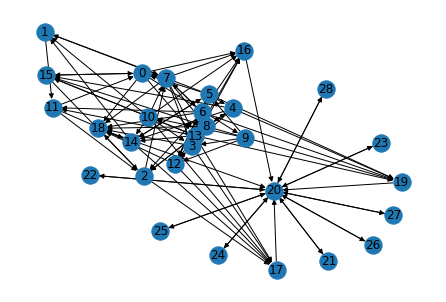

In [87]:
graph = Graph(16, 4, 8, -1)
graph.draw()

In [8]:
df = pd.DataFrame(columns=['InDegree-HITS Difference',
                           'InDegree-PageRank Difference',
                           'PageRank-HITS Difference',
                           'connectivity',
                           'n_nodes',
                           'seed'])

for connectivity in range(-2, 3):
    for n_nodes in [4,6,8,10]:
        graph = None
        
        count = 0
        seed = 0
        while count < 32:
            graph = create_random_graph(n_nodes, connectivity, seed)

            while not nx.is_weakly_connected(graph.to_nx()):
                seed += 1
                graph = create_random_graph(n_nodes, connectivity, seed)

            df.loc[df.shape[0]] = graph.get_ranking_diffs()
            count += 1
            seed  += 1

for column in ['InDegree-HITS Difference',
               'InDegree-PageRank Difference',
               'PageRank-HITS Difference',
               'n_nodes']:
    df[column] = df[column].astype('int')
df

,InDegree-HITS Difference,InDegree-PageRank Difference,PageRank-HITS Difference,connectivity,n_nodes,seed
0,0,2,2,-2,4,2
1,0,0,0,-2,4,10
2,2,2,4,-2,4,38
3,2,4,2,-2,4,55
4,2,2,4,-2,4,57
...,...,...,...,...,...,...
635,4,10,10,2,10,27
636,8,6,12,2,10,28
637,8,12,14,2,10,29
638,12,8,20,2,10,30


In [9]:
fig = px.scatter_ternary(df,
                         a="InDegree-HITS Difference",
                         b="InDegree-PageRank Difference",
                         c="PageRank-HITS Difference",
                         #size='n_nodes',
                         color='connectivity')
fig.show()

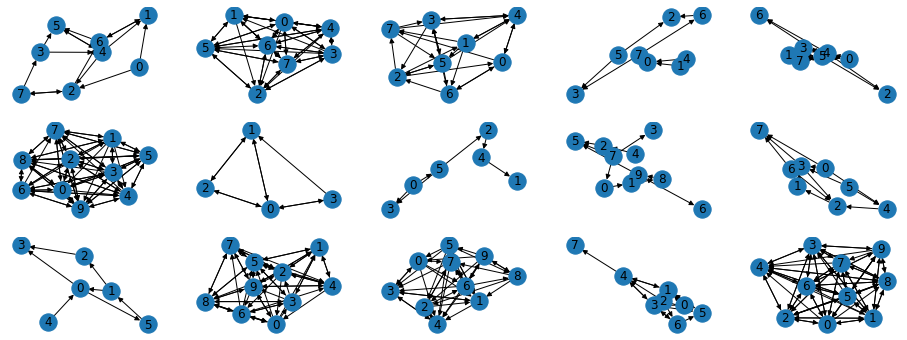

In [10]:
s = df.columns[1]
d = plot_sample_graphs(df,
                   5, 3,
                   (16, 6),
                   )

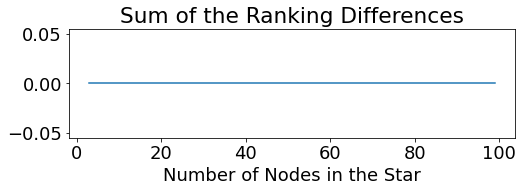

In [78]:
graph = Graph(1,1,1)
star_df = pd.DataFrame(columns=["%s"%i for i in range(7)])
for d in range(3, 100):
    adjacency = np.zeros((d,d))
    adjacency[1:,0] = 1
    graph.set_adjacency(adjacency)
    diffs = graph.get_ranking_diffs()
    diffs.append(d)
    star_df.loc[d-3] = diffs
plt.figure(figsize=(8,2))
plt.title("Sum of the Ranking Differences")
plt.xlabel("Number of Nodes in the Star")
plt.plot(star_df['6'], star_df['1'])

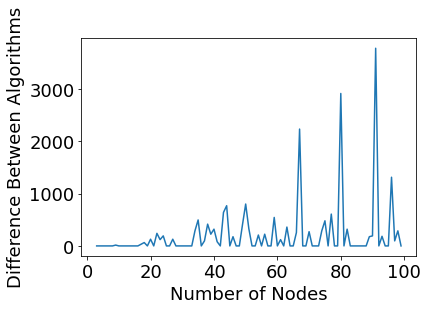

In [82]:
graph = Graph(1,1,1)
connected_df = pd.DataFrame(columns=["%s"%i for i in range(7)])
for d in range(3, 100):
    graph.set_adjacency(np.ones((d,d)) - np.identity(d))
    diffs = graph.get_ranking_diffs()
    diffs.append(d)
    connected_df.loc[d-3] = diffs

plt.figure
plt.xlabel("Number of Nodes")
plt.ylabel("Difference Between Algorithms")
plt.plot(connected_df['6'], connected_df['1'])

In [85]:
connected_df

,0,1,2,3,4,5,6
0,0,0,0,2,10,32,3
1,0,0,0,2,10,32,4
2,0,0,0,2,10,32,5
3,0,0,0,2,10,32,6
4,0,0,0,2,10,32,7
...,...,...,...,...,...,...,...
92,0,0,0,2,10,32,95
93,0,1312,1312,2,10,32,96
94,0,96,96,2,10,32,97
95,0,288,288,2,10,32,98


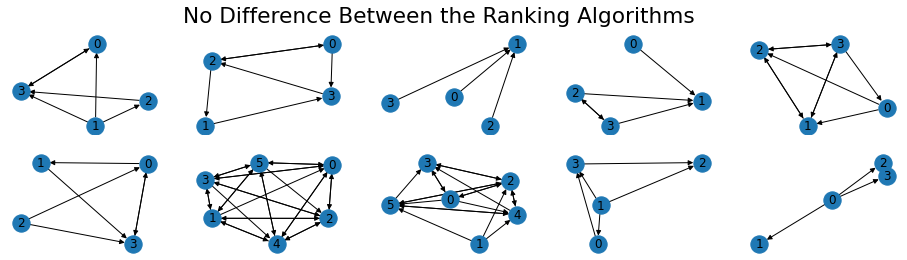

,n_nodes,connectivity,seed
406,4,1,22
145,4,-1,38
152,4,-1,54
7,4,-2,74
401,4,1,17
283,4,0,29
571,6,2,27
432,6,1,16
279,4,0,25
142,4,-1,30


In [11]:
plot_sample_graphs(df[df.iloc[:, :3].sum(axis=1) == 0],
                   5, 2,
                   (16,4),
                   "No Difference Between the Ranking Algorithms")

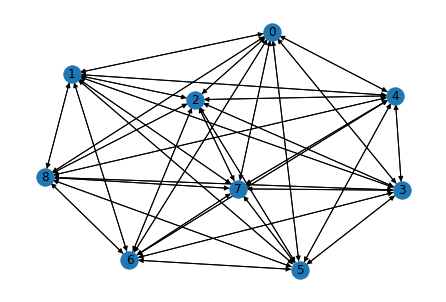

In [47]:
graph.set_adjacency(np.ones((9,9)) - np.identity(9))
diffs = graph.get_ranking_diffs()
graph.draw()

In [20]:
graph.get_ranking_diffs()

[0, 0, 0, 2, 10, 32]